## Camera Calibration 

We are given 40 images of 3D checkerboards from a video for camera calibration. These frames contain two checkerboards with 20 mm and 40 mm grid sizes. The images are taken from different angles with different surroundings.    



We perform the following tasks:
* Choose **one image** for the calibration and explain why you choose it.
* After the chosen, please use this image to calibrate the camera, which needs to calculate the intrinsic matrix $\mathbf{K}$, rotation matrix $\mathbf{R}$, and translation vector $\mathbf{t}$. 

#### The camera calibration process:
---
1. Detect keypoints of the checkerboard
2. Fix the world coordinate and get the corresponding keypoints world coordinate. 
3. Generate equations with 3D-2D matching pair
4. Solve projection matrix $\mathbf{P}$ with equations
5. Decompose $\mathbf{K}$,$\mathbf{R}$, $\mathbf{t}$ from $\mathbf{P}$

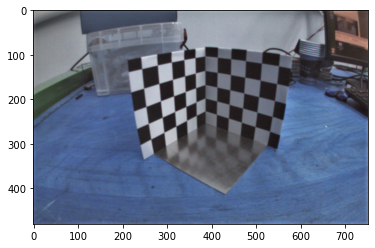

(480, 752, 3)


In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img=cv2.imread('./data/camera_calib/30.png',cv2.IMREAD_COLOR)   # load the image you choose
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
checkerboard_size=(9,4)   # Number of inner corners per a chessboard row/column, which will be use in cv2.findChessboardCorners()
checkerboard_length=20    # the board grid size you choose
plt.imshow(img)
plt.show()
print(img.shape)

## 1. Detect keypoints of the checkboard

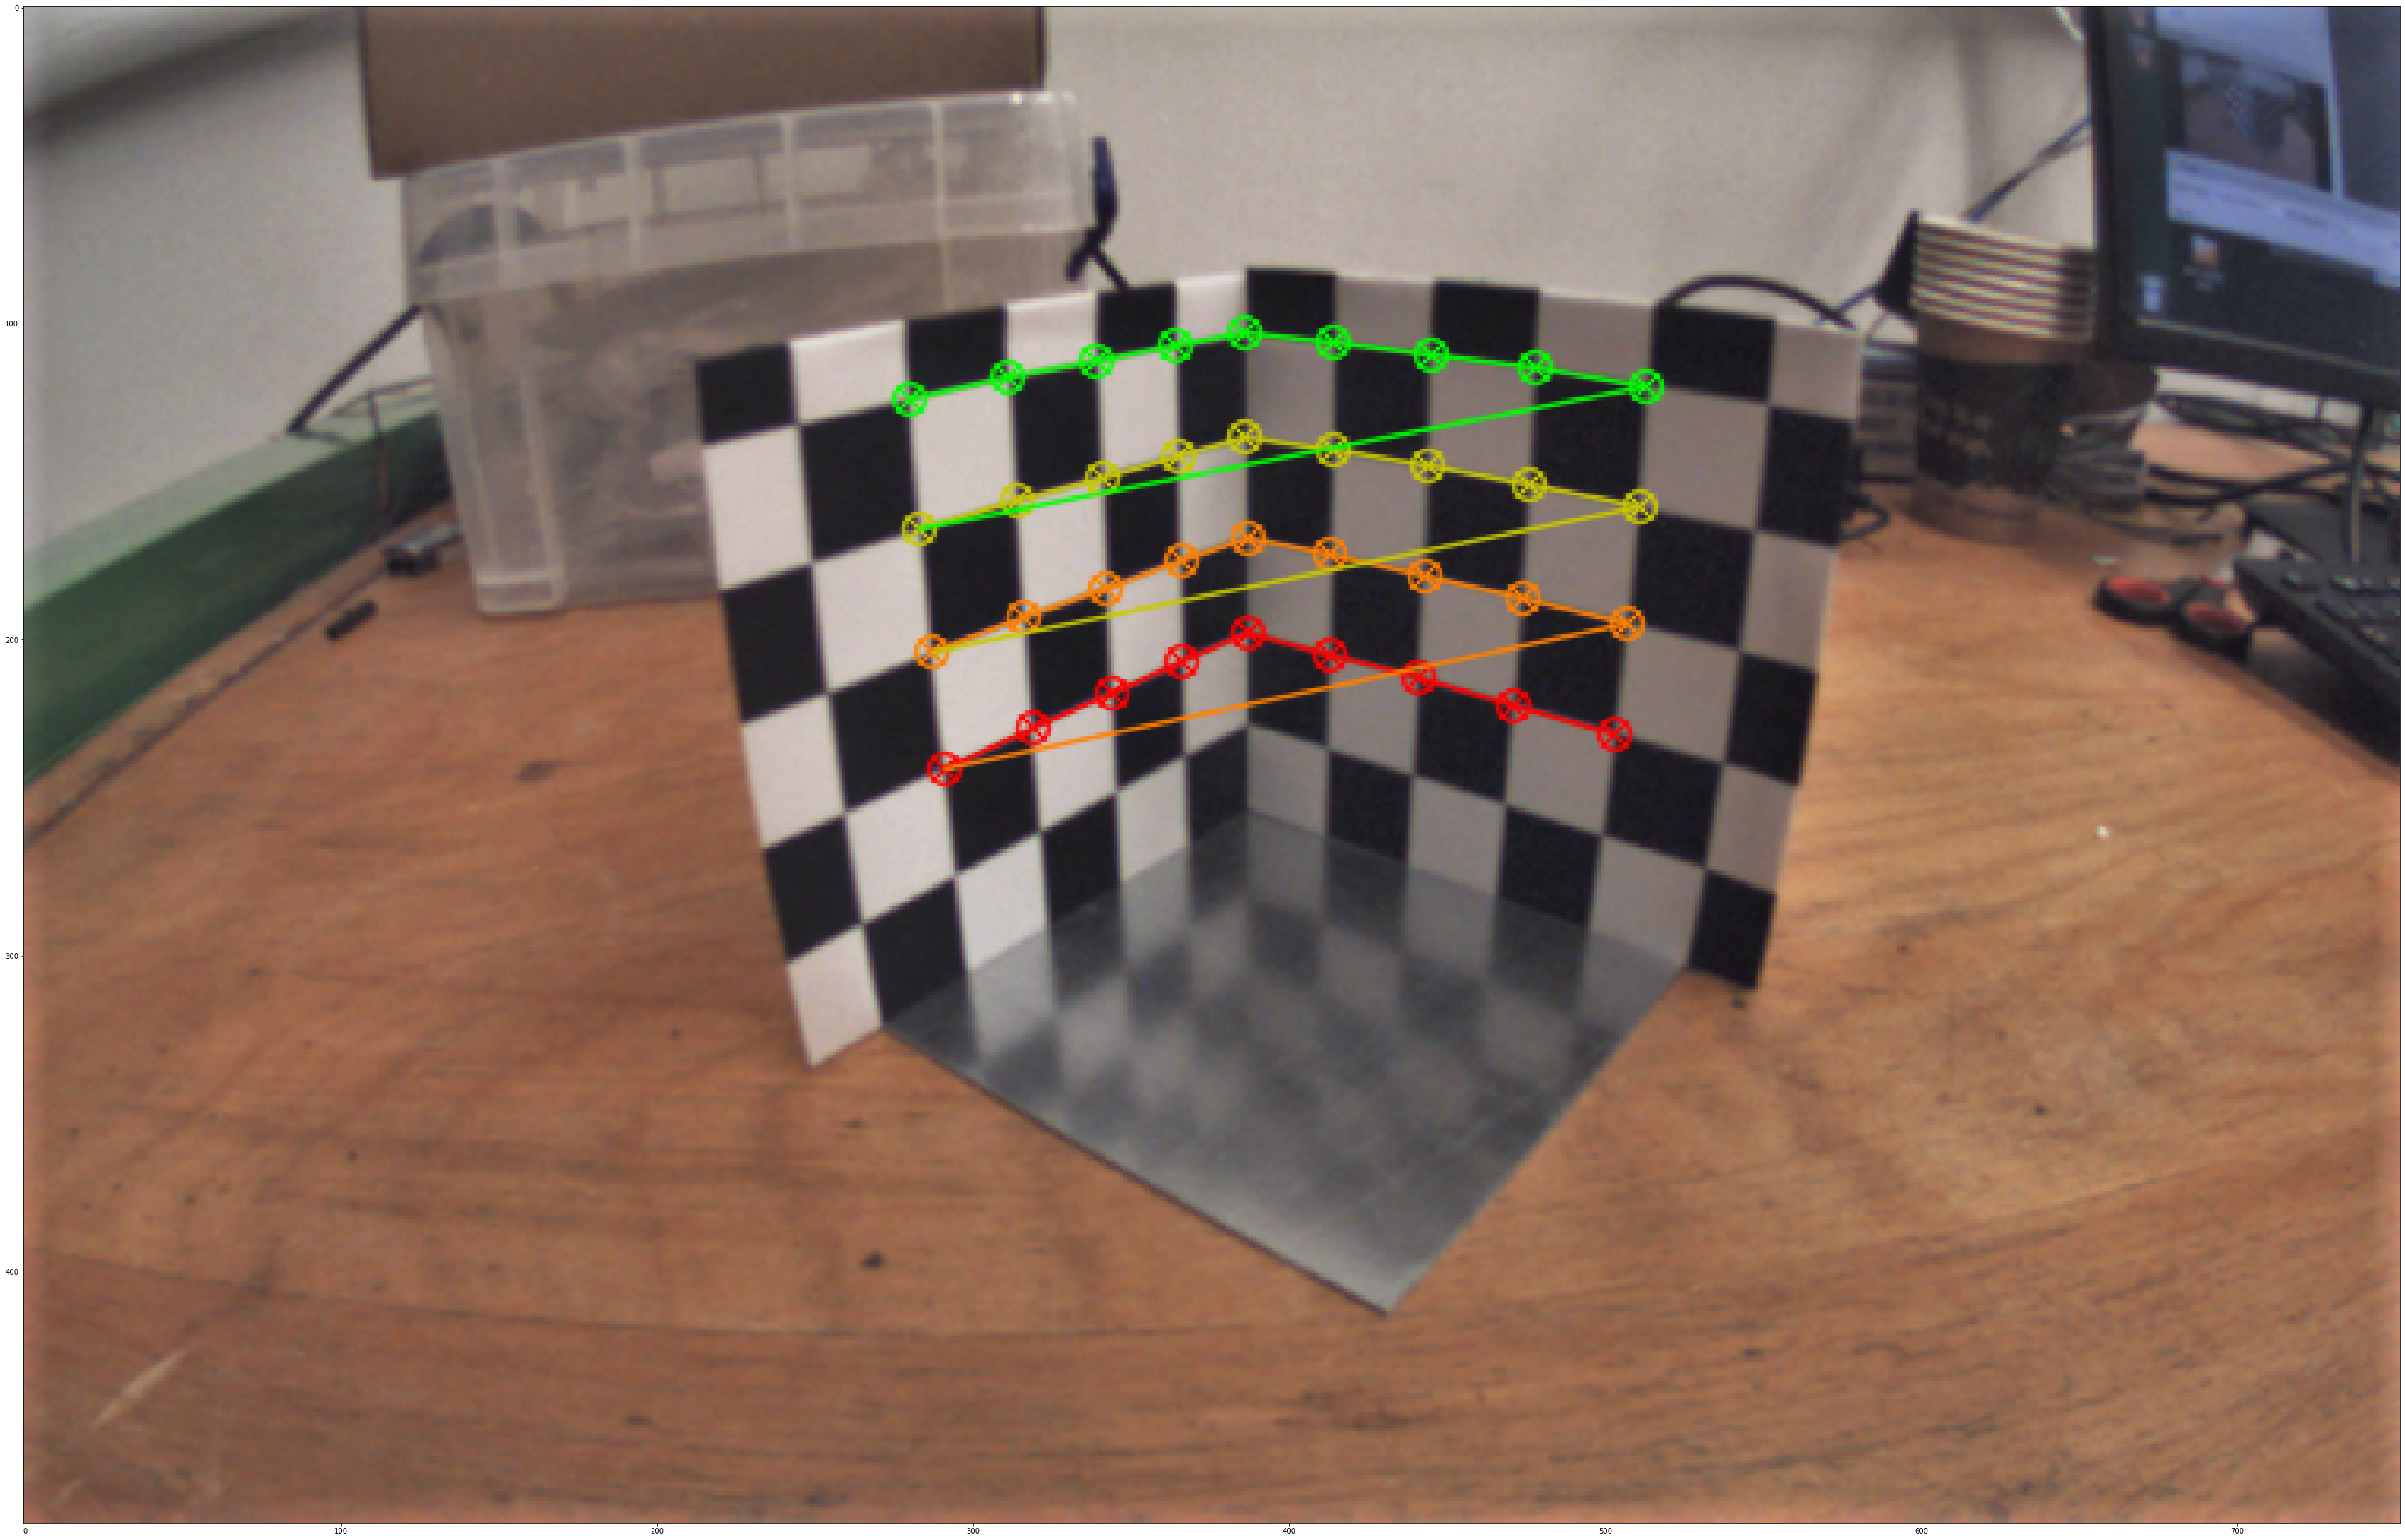

In [2]:
def detect_keypoints(img,checkerboard_size):
    '''
    find checkerboard keypoints
    
    Args:
        image (np.ndarray): Image (height x width x 3).
        checkerboard size (int,int): Number of inner corners per a chessboard row and column
        
    Returns:
        np.ndarray: Output array of detected corners (inner corners number x 2). 
    ''' 
    
    # Detect Chessboard corners
    ret,corners=cv2.findChessboardCorners(img,checkerboard_size,None)

    # refine the corner locations with sub-pixel accuracy
    if ret==True:
        criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 3, 0.1) # stop after 3 iterations or the accuracy of 0.1 is achieved
        # convert image to gray scale
        img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        corners2=cv2.cornerSubPix(img_gray,corners,(5,5),(-1,-1),criteria) 
        img_points.append(corners2)

    img_corner=cv2.drawChessboardCorners(img,checkerboard_size,corners2,ret) # draw detected corners
    img_corner2 = img_corner[:,:,::-1] 	# transform image from bgr to rgb
    plt.figure(figsize=(60,60))
    plt.imshow(img_corner2)
    plt.show()

    return np.reshape(img_points, (-1, 2))

img_points=[]
img_points=detect_keypoints(img,checkerboard_size)

## 2. Fix the world coordinate and get the corresponding keypoints world coordinate

In [3]:
def fix_world_points(checkerboard_size,checkerboard_length):
    # fix the world coordinate and get cooresponding keypoints in the world coordinates
    num_h=checkerboard_size[0]
    num_v=checkerboard_size[1]
    objp = []

    for i in range(num_v):
        for j in range(num_h):
            if j<5:
                # objp_point=[0,(5-j)*checkerboard_length,(5-i)*checkerboard_length]
                objp_point=[(4-j)*checkerboard_length,0,(4-i)*checkerboard_length]
                objp.append(objp_point)
            else:
                # objp_point=[(j-5)*checkerboard_length,0,(5-i)*checkerboard_length]
                objp_point=[0,(j-4)*checkerboard_length,(4-i)*checkerboard_length]
                objp.append(objp_point)


    return np.reshape(np.array(objp), (-1, 3))

world_points=fix_world_points(checkerboard_size,checkerboard_length)
# print(world_points)

## 3. Generate equations with 3D-2D matching pair

In [4]:
def coefficients_from_3d_2d(image: np.ndarray, world: np.ndarray):
    """Get coefficients for the polynomial equation.

    Args:
        image (np.ndarray): 2D vector (u, v).
        world (np.ndarray): 3D vector (x, y, z).

    Returns:
        np.ndarray: Coefficients of 2 rows of A (2x12).
    """
    res = np.zeros((2, 12))
    u, v = image
    x, y, z = world

    # p1 * X - u * p * X = 0
    res[0][0] = x
    res[0][1] = y
    res[0][2] = z
    res[0][3] = 1
    res[0][8] = -u * x
    res[0][9] = -u * y
    res[0][10] = -u * z
    res[0][11] = -u

    # p2 * X - v * p3 * X = 0
    res[1][4] = x
    res[1][5] = y
    res[1][6] = z
    res[1][7] = 1
    res[1][8] = -v * x
    res[1][9] = -v * y
    res[1][10] = -v * z
    res[1][11] = -v
    return res

## 4. Solve projection matrix 𝐏

In [5]:
def solve_P(A: np.ndarray):
    """Solve for P using A.

    Args:
        A (np.ndarray): Matrix A (2N, 12).

    Returns:
        np.ndarray: Matrix P (3x4).
    """
    
    _, _, V = np.linalg.svd(A)
    P = V[-1].reshape((3,4))
    
    return P

## 5. Decompose 𝐊, 𝐑, t from P

In [6]:
def decompose_P(P: np.ndarray):
    """Decompose P into K, R, t.

    Args:
        P (np.ndarray): Matrix P (3x4).

    Returns:
        K (np.ndarray): Matrix K (3x3).
        R (np.ndarray): Matrix R (3x3).
        t (np.ndarray): Matrix t (3x1).
    """
    KR = P[:, :3]
    KKT = KR @ KR.T  # KKT = KR @ KR.T = K @ K.T
    norm=KKT[2, 2] 
    KKT /= norm
    sign = P[0][3] / np.abs(P[0][3])
    P /= np.sqrt(norm) * sign
    KR = P[:, :3]
    Kt = P[:, 3]

    u0 = KKT[0][2]
    v0 = KKT[1][2]
    fy = np.sqrt(KKT[1][1] - v0 ** 2)
    s = (KKT[0][1] - u0 * v0) / fy
    fx = np.sqrt(KKT[0][0] - u0 ** 2 - s ** 2)
    K = np.array([[fx, s, u0], [0, fy, v0], [0, 0, 1]])
    R = np.linalg.inv(K) @ KR  # R = K^-1 @ KR
    t = np.linalg.inv(K) @ Kt  # t = K^-1 @ Kt
    return K, R, t

In [7]:
def calibrate_3d_2d(image_points: np.ndarray, world_points: np.ndarray):
    """Calibrate 3D to 2D.

    Args:
        image_points (np.ndarray): 2D points (N, 2).
        world_points (np.ndarray): 3D points (N, 3).

    Returns:
        K (np.ndarray): Matrix K (3x3).
        R (np.ndarray): Matrix R (3x3).
        t (np.ndarray): Matrix t (3x1).
    """
    
    A = np.zeros((2 * image_points.shape[0], 12))
    for i in range(image_points.shape[0]):
        A[2 * i: 2 * i +
            2] = coefficients_from_3d_2d(image_points[i], world_points[i])
    P = solve_P(A)
    K, R, t = decompose_P(P)
    return K, R, t



K, R, t = calibrate_3d_2d(img_points, world_points)
print(K)
print(R)
print(t)

[[480.18370356   3.00234671 403.92486154]
 [  0.         476.6512031  203.19433653]
 [  0.           0.           1.        ]]
[[ 0.80929806 -0.58727477 -0.01204095]
 [ 0.21899646  0.28264191  0.93389191]
 [-0.54504789 -0.75843384  0.35735264]]
[ -9.73075245 -78.14461424 274.6414667 ]


# 